## Functions

##### Initialization

In [ ]:
# Base libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)

# Convert currencies
#!pip install currencyconverter
#from currency_converter import CurrencyConverter

# Convert strings with commas as thousand separators
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8') 

# Convert datatimes
from datetime import datetime

# Read zips
from zipfile import ZipFile

# Forecast models
#!pip install -U statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import *
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
from sklearn.feature_extraction import  *
from sklearn.base import *
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.svm import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.feature_selection import *
from sklearn.neighbors import *
from imblearn.over_sampling import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

# Tensorflow
import tensorflow as tf
from keras.models import Sequential
from keras.models import *
from keras.layers import LSTM
from keras.layers import *
!pip install scikeras
from scikeras.wrappers import KerasClassifier

# Warnings
import warnings

# To register elapsed time
import time

# Save objects to files
import pickle

def mount_drive_select_path(drive_path = "/content/drive/MyDrive/UA/5º Ano/Tese"):

  # Mount drive
  from google.colab import drive
  drive.mount('/content/drive')

  # Drive path
  %cd $drive_path

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##### Read data

In [ ]:
def zip_2_dataframe(zip_name, file_name, filetype):
  
  # Open zip file
  zip_file = ZipFile(zip_name, 'r')  

  # Open file
  data_file = zip_file.open(file_name)

  if filetype == "csv":
    df = pd.read_csv(data_file)
  if filetype == "json":
    df = pd.read_json(data_file, lines=True)

  return df

##### Data cleaning

In [ ]:
# Convert a string to datetime data format
def str_2_date(str_date, date_format):
  return datetime.strptime(str(str_date), date_format)

# Replace the last ocurrence of a char in a string by another char
def replace_last_occurrence(str, old_char, new_char):
  
  last_index = str.rfind(old_char)
  if last_index == -1:    # the char wasn't found
    return str
  else:
    return str[:last_index] + new_char + str[last_index+1:]


# Remove commas, dots and currency signs from the prices
def clean_prices(price):

  # Sol peruano (doesn't have decimal cases - thousands are separated with commas)
  if price[0] == "S":
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[2:])                              # remove the sign of the currency
    return price
  
  # Dollar (always has decimal cases (i think) - thousands and decimals are both separated by commas)
  if price[0] == "$":
    price = replace_last_occurrence(price, ",", ".")      # replace comma that separates decimals by a dot
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[1:])                              # remove the sign of the currency
    return price
  
  # Euro (decimal cases, if there are any, are separated by dots - thousands are separated by commas)
  if price[0] == "€":
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[1:])                              # remove the sign of the currency
    return price                              
  
  return np.nan


# Convert all prices to a base currency (euro)
def convert_prices_to_euros(row, currency_column, price_column, sol = 0.24, dollar = 1/1.0993):

  currency = row[currency_column]
  price = row[price_column]
  
  if currency in ["€"]:
    return price

  if currency in ["$"]:
    return dollar*price 
  
  if currency in ["S"]:
    return sol*price 


def clean_data(df):

  df = df.copy()
  
  # Convert timestamps' strings to data of date format
  df["timestamp"] = df["timestamp"].apply(str_2_date, args = ('%Y%m%d',))

  # Get type of currency
  df["currency"] = df["price"].str[0]

  # Clean prices (remove commas, dots, and currency signs)
  df["price_clean"] = df["price"].apply(clean_prices)

  # Convert all prices to a base currency (euro)
  df["price_euro"] = df.apply(convert_prices_to_euros, args = ("currency", "price_clean"), axis = 1)

  return df

##### Select time series

In [ ]:
# Select a particular time series based on its ID - ID can be of type: product_id, product_group_id, company_id

def select_time_series(df, id_type, id, price = "price_euro"):

  df = df.copy()

  # Select all rows that have id
  df = df[df[id_type].isin(id)]
  
  # Information about the selected products
  info = {
      "product_id": list(df["product_id"].unique()),
      "product_group_id": list(df["product_group_id"].unique()),
      "company_id": list(df["company_id"].unique()),
      "product": list(df["product"].unique()),
      "country_company": list(df["country_company"].unique()),
      "offer_type": list(df["offer_type"].unique())
      }
  
  return df, info

In [ ]:
def prepare_time_series_univariate(df, price = "price_euro", interpolation_method = "liner"):
  df = df.copy()
  df = df[["timestamp", price]].set_index("timestamp")

  df = fill_miss_vals(df)
  #df = add_stock_info(df)

  df[price] = interpolate(df[price], method = interpolation_method)

  return df

##### Transform data series

In [ ]:
# Apply differences to a time series panda dataframe
def diff_time_series_df(df, diff_order, columns = "all"):
  
  # diff_order - how many times data must be differenced
  # columns - list of the names of columns that will be differenced

  df = df.copy()

  if columns == "all":
    columns = df.columns

  for order in range(diff_order):
    df[columns] = df[columns].diff()
  
  df = df.dropna()

  return df


# Apply differences to a time series panda series
def diff_time_series(df, diff_order):
  
  # diff_order - how many times data must be differenced

  df = df.copy()

  for order in range(diff_order):
    df = df.diff()
  
  df = df.dropna()

  return df

##### Add unique identifiers to data

In [ ]:
def create_id(df, id_name, unique_identifiers, loc = 0):
  df = df.copy()
  df.insert(loc=loc, column=id_name, value=df.set_index(unique_identifiers).index.factorize()[0]+1)
  return df

def add_ids(df):
  df = df.copy()

  df = create_id(df, "product_id", ['company','country','product','offer_type'])
  df = create_id(df, 'product_group_id', ['product','offer_type'])
  df = create_id(df, 'company_id', ['company','country'])
  df.insert(loc=0, column='country_company', value= df.country + " " + df.company)

  return df

##### Order time series by number of changes

In [ ]:
# def get_ordered_number_of_changes(df):
  
#   df_changes = pd.DataFrame({'n_changes' : df.groupby('product_id')['price_clean'].nunique()}).reset_index().sort_values(by = "n_changes", ascending = False)  
#   product_id_ord = df_changes["product_id"].to_numpy()

#   return df_changes, product_id_ord

def get_ordered_number_of_changes(df, id, time, value, interpolation_method):
  
  df = df.copy()
  df = df[[id, value, time]].sort_values([id, time])                            # Order rows of dataframe by id and by time
  
  df = df.groupby(id)[value, time].apply(prepare_time_series_univariate, **{"price" : value, "interpolation_method" : interpolation_method})                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  
  n_samples = df.groupby(id)[value].size()                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  
  df["n_changes"] = df.groupby(id)[value].diff()                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  df = df.iloc[1:]                                                              # Remove the first row of the dataframe, as it is an NaN
  df = df.groupby(by = [id])["n_changes"].agg(lambda x: x.ne(0).sum())            # Count how many differences are different than zero. This number will correspond to the number of changes in the timeseries
  product_id_ord = df.sort_values(ascending = False).index.to_numpy()           # Get a list of product_ids ordered by number of changes
  
  df = pd.concat([df, n_samples], axis = 1)
  df.columns = ["n_changes", "n_samples"]

  return df, product_id_ord

##### Missing values

In [ ]:
def add_stock_info(df, price = "price_euro"):
  df = df.copy()
  df["days_out_of_stock"] = df[price].isna().astype(int).groupby(df[price].notnull().astype(int).cumsum()).cumsum()
  df["out_of_stock"] = df[price].isna().astype(int)
  return df

# Add the days that are not present in a certain time series
def fill_miss_vals(df, time_column_name = "timestamp"):

  # df - data of a single time series
  # time_column_name - name of the column with the information of timestamps

  df = df.copy()

  idx = pd.date_range(min(df.index), max(df.index))
  df = df.reindex(idx, fill_value=np.nan)
  df.index.name = time_column_name

  return df

# Interpolation
def interpolate(df, method):
  # The interpolate methods that I used were either "linear" (linear interpolation) or "ffill" (repeat last value)
  return df.copy().interpolate(method = method, limit_direction ='forward')  

##### Visualize data

In [ ]:
# Set size of plot
def set_fig_size(size):
  plt.rcParams['figure.figsize'] = size

# Plot the time series of individual products
def show_time_series_product(df, info, price):
  
  df = df.copy()

  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df["product_id"] = df["product_id"].astype('category')

  plt.rcParams['figure.figsize'] = (10, 5)
  ax = sns.lineplot(x="timestamp", y=price, hue = "product_id", data=df, marker = 'o')
  
  if len(product_id) == 1:
    ax.set_title(info["country_company"][0] + " - " + info["product"][0] + " - " + info["offer_type"][0])
    print("Number of samples: ", len(df))

# Plot the time series of all products that belong to a certain group
def show_time_series_product_group(df, info, price):

  df = df.copy()

  plt.rcParams['figure.figsize'] = (10, 5)
  ax = sns.lineplot(x="timestamp", y=price, hue = "country_company", data=df, marker = 'o')
  ax.set_title(info["product"][0] + " - " + info["offer_type"][0]);

# Plot the time series that belong to a certain company from a certain country
def show_time_series_country_company(df, info, price):

  df = df.copy()

  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df["product_id"] = df["product_id"].astype('category')

  plt.rcParams['figure.figsize'] = (10, 5)
  ax = sns.lineplot(x="timestamp", y=price, hue = "product_id", data=df, marker = 'o', legend = False)
  ax.set_title(info["country_company"][0]);


def show_time_series(df, id_type, info, price = "price_euro"):

  df = df.copy()
  
  if id_type == "product_id":
    show_time_series_product(df, info, price)
  if id_type == "product_group_id":
    show_time_series_product_group(df, info, price)
  if id_type == "company_id":
    show_time_series_country_company(df, info, price)

##### Performance Metrics

In [ ]:
def get_nmse(y_obs, y_pred):
  y_obs = y_obs.to_numpy().reshape((y_obs.shape[0], 1))
  y_pred = y_pred.to_numpy().reshape((y_pred.shape[0], 1))

  if len(y_obs) != len(y_pred):
    print("The lenghts of the input arrays don't match.")

  nmse = 20*np.log10(np.sqrt(sum((y_obs-y_pred)**2)/sum(y_obs**2)))

  return nmse[0]

In [ ]:
def get_mape(y_obs, y_pred):
  y_obs = y_obs.to_numpy().reshape((y_obs.shape[0], 1))
  y_pred = y_pred.to_numpy().reshape((y_pred.shape[0], 1))
  
  if len(y_obs) != len(y_pred):
    print("The lenghts of the input arrays don't match.")

  n = len(y_obs)
  mape = 1/n*sum(abs((y_obs-y_pred)/y_obs))

  return mape[0]

##### Test stationarity

In [ ]:
def adf_test_results(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput.round(4))


def kpss_test_results(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


def adf_test(timeseries, p_value_max):
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value

    dfoutput["is_stationary"] = (dfoutput.loc["p-value"] < p_value_max)

    return dfoutput

def kpss_test(timeseries, p_value_max):
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3],
        index=[
               "Test Statistic",
               "p-value",
               "Lags Used"
               ]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    
    kpss_output["is_stationary"] = (kpss_output.loc["p-value"] > p_value_max)

    return kpss_output


def test_stationarity(timeseries, stationary_tests, p_values_max):
  
  is_stationary = []
  p_values = []
  test_results = []

  for stationary_test, p_value_max in zip(stationary_tests, p_values_max):
    test_result = stationary_test(timeseries, p_value_max)
    is_stationary.append(test_result.loc['is_stationary'])
    p_values.append(test_result.loc['p-value'])
    test_results.append(test_result)

  print("P-Values: ", p_values)

  is_overall_stationary = all(is_stationary)
  if is_overall_stationary:
    print("The timeseries is stationary.")
  else:
    print("Can't confirm the series is stationary.")

  return p_values, test_results, is_stationary, is_overall_stationary

##### Linear models

In [ ]:
def get_lags(timeseries, diff_order, nlags = 40, alpha = 0.05):
  
  timeseries_diff = diff_time_series(timeseries, diff_order)
  acf_coeff,  acf_confint  = acf(timeseries_diff, nlags=nlags, alpha = alpha)
  pacf_coeff, pacf_confint = pacf(timeseries_diff, nlags=nlags, alpha = alpha)

  acf_lags  = tuple(((acf_coeff  > acf_confint[:,1]-acf_coeff)   | (acf_coeff  < acf_confint[:,0]-acf_coeff)).astype(int))
  pacf_lags = tuple(((pacf_coeff > pacf_confint[:,1]-pacf_coeff) | (pacf_coeff < pacf_confint[:,0]-pacf_coeff)).astype(int))

  return acf_lags, pacf_lags

In [ ]:
def plot_results(title, obs, pred, confint, fig_size):
    
    # Graph
    fig, ax = plt.subplots(figsize=(fig_size))
    ax.set(title=title, xlabel='Date', ylabel='Price/€')

    # Plot data points
    obs.plot(ax=ax, style='-o', label='Observed')

    # Plot predictions
    pred.plot(ax=ax, style='r--', label='One-step-ahead forecast')
    if confint != None:
      ci = confint
      ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

    legend = ax.legend(loc='lower right')
    #ax.set_ylim([min(obs)-100, max(obs)+100])

##### Naive models

In [ ]:
class EXPONENTIAL_SMOOTHING:
  def __init__(self):
    pass

  def get_prediction(self, data, smoothing_level):
    
    self.data = data.copy()
    self.beg = 11

    # Series to store one-step-ahead predictions
    self.pred = self.data.iloc[self.beg:].copy()
  
    # Total number of observed samples
    end = len(self.data)

    for i in range(self.beg, end):
      self.pred.iloc[i-self.beg] = SimpleExpSmoothing(self.data.iloc[:i-1], initialization_method="heuristic").fit(smoothing_level=smoothing_level, optimized=False).forecast()

    return self.pred

  def get_metric(self, metric):
    return metric(self.data.iloc[self.beg:], self.pred)

  def plot_results(self):

    fig, ax = plt.subplots(figsize=(10,5))
    ax.set(title=info["product"][0] + " - Exponential Smoothing Prediction", xlabel='Date', ylabel='Price/€')

    # Plot data points
    self.data.plot(ax=ax, style='-o', label='Observed')

    # Plot predictions
    self.pred.plot(ax=ax, style='r--', label='One-step-ahead forecast')

    legend = ax.legend(loc='lower right')

##### Characteristics of timeseries

In [ ]:
def get_variance(series):
  return np.sum((series - np.mean(series))**2)/len(series)

##### Strings

In [ ]:
def add_pre_suf(word, pre_suf, pre_suf_flag):
  if pre_suf_flag == "pre":
    return pre_suf + word
  elif pre_suf_flag == "suf":
    return word + pre_suf
  else:
    return word

# Notebook: LSTM for prediction of price change

- **Goal**: study of LTSM models for prediction of price change

In [ ]:
mount_drive_select_path()

Mounted at /content/drive
/content/drive/MyDrive/UA/5º Ano/Tese


### Read data

#### Read data

In [ ]:
#zip_name = "data/catalog_sample.zip"
#file_name = "catalog_sample.json"
#filetype = "json"
#df_og = zip_2_dataframe(zip_name, file_name, filetype)
df_og = pd.read_pickle("df_og")

#### Clean data and add unique identifiers to products, product groups and companies

In [ ]:
#df = clean_data(df_og.copy())
#df = add_ids(df)
df = pd.read_pickle("df_clean")

In [ ]:
df

,country_company,company_id,product_group_id,product_id,product,country,company,price,timestamp,offer_type,currency,price_clean,price_euro
0,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-22,unlocked,$,799.99,727.726735
1,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-21,unlocked,$,799.99,727.726735
2,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-20,unlocked,$,799.99,727.726735
3,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-19,unlocked,$,799.99,727.726735
4,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-18,unlocked,$,799.99,727.726735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
602051,CL claro,19,958,3222,huawei Y9S 128GB,CL,claro,"$229,990",2020-06-21,unlocked,$,229.99,209.214955
602052,CO Claro,5,958,3234,huawei Y9S 128GB,CO,Claro,"$1,168,900",2020-06-21,unlocked,$,1168.90,1063.313017
602053,CO Tigo,3,958,3228,huawei Y9S 128GB,CO,Tigo,"$1,079,900",2020-06-21,unlocked,$,1079.90,982.352406
602054,PE Movistar,23,960,3236,huawei Y9S 128GB,PE,Movistar,"S/1,519",2020-06-20,postpaid_portability,S,1519.00,364.560000


#### Interpolate data

In [ ]:
id = "product_id"
value = "price_euro"
time = "timestamp"
interpolation_method = "ffill"

#df_inter = df[[id, value, time]].sort_values([id, time])                         
#df_inter = df_inter.groupby(id)[value, time].apply(prepare_time_series_univariate, **{"price" : value, "interpolation_method" : interpolation_method})
#df_inter.to_pickle("df_inter_fill")
df_inter = pd.read_pickle("df_inter_fill")

#### Order products by number of changes in time series

In [ ]:
#df_changes_linear, product_id_ord_linear = get_ordered_number_of_changes(df, "product_id", "timestamp", "price_clean", interpolation_method = "linear")
#df_changes_fill, product_id_ord_fill = get_ordered_number_of_changes(df, "product_id", "timestamp", "price_clean", interpolation_method = "ffill")

#counts = []
#for i in range(min(df_changes_fill["n_changes"]), max(df_changes_fill["n_changes"])):
#  counts.append(len(df_changes_fill["n_changes"][df_changes_fill["n_changes"] > i]))

#fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1)
#ax.plot(counts)
#plt.title("Nº of examples that have more than a certain number of changes")

#df_changes_linear.to_pickle("df_changes_linear")
#df_changes_fill.to_pickle("df_changes_fill")
#np.save("product_id_ord_linear", product_id_ord_linear)
#np.save("product_id_ord_fill", product_id_ord_fill)

In [ ]:
df_changes_linear = pd.read_pickle("df_changes_linear")
df_changes_fill = pd.read_pickle("df_changes_fill")
product_id_ord_linear = np.load("product_id_ord_linear.npy")
product_id_ord_fill = np.load("product_id_ord_fill.npy")

### Visualize time series

In [ ]:
product_id = [product_id_ord_fill[150]]
df_product, info = select_time_series(df, "product_id", product_id)

product_group_id = info["product_group_id"]
company_id = info["company_id"]

Number of samples:  165


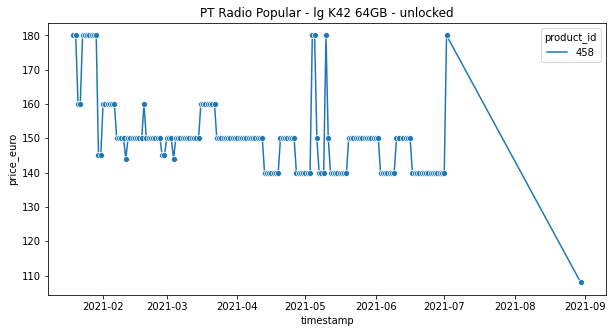

In [ ]:
show_time_series(df_product, "product_id", info)

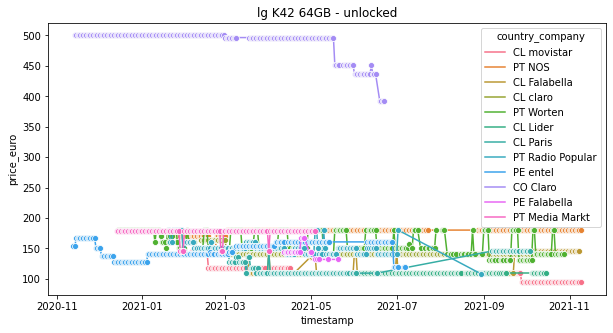

In [ ]:
df_product_group, info = select_time_series(df, "product_group_id", product_group_id)
show_time_series(df_product_group, "product_group_id", info)

Text(0.5, 1.0, 'Differencing Order: 1')

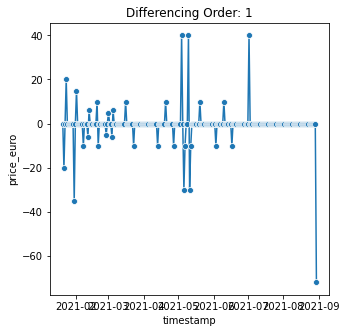

In [ ]:
product_id = [product_id_ord_fill[150]]

df_product, info = select_time_series(df, "product_id", product_id)
df_product = prepare_time_series_univariate(df_product, price = "price_euro", interpolation_method = "ffill")

diff_order = 1
df_diff = diff_time_series_df(df_product, diff_order, columns = "price_euro")

# Difference
set_fig_size((5, 5))
sns_line = sns.lineplot(x = "timestamp", y = "price_euro", data = df_diff, marker = 'o')
sns_line.set_title("Differencing Order: " + str(diff_order))

### Arrange the data as features

In [ ]:
def convert_2_states_df(df):
  return df.apply(convert_2_states)

def convert_2_states(data):
  data_states = data.diff()
  data_states.loc[data_states > 0] = 2
  data_states.loc[data_states == 0] = 1
  data_states.loc[data_states < 0] = 0
  return data_states

def series_to_supervised(data, n_in=2, n_out=1, dropnan=True):
	
  """
  Frame a time series as a supervised learning dataset.
  Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
  Returns:
    Pandas DataFrame of series framed for supervised learning.
  """

  data = list(data)
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

def transform_2_features(df, lags):
  df = df.groupby(id)[value].apply(series_to_supervised, **{"n_in" : lags})
  df_lags = df.groupby(id).apply(convert_2_states_df).add_suffix("_class")
  df_diff = df.groupby(id).diff().add_suffix("_diff")
  return pd.concat([df, df_lags, df_diff], axis = 1)

In [ ]:
id = "product_id"
value = "price_euro"
time = "timestamp"
interpolation_method = "ffill"

df_inter = df[[id, value, time]].sort_values([id, time])                         
df_inter = df_inter.groupby(id)[value, time].apply(prepare_time_series_univariate, **{"price" : value, "interpolation_method" : interpolation_method})
df_lags = transform_2_features(df_inter, 7)
#df_lags.to_pickle("df_lags_7")
df_lags = transform_2_features(df_inter, 14)
#df_lags.to_pickle("df_lags_14")
df_lags = transform_2_features(df_inter, 21)
#df_lags.to_pickle("df_lags_21")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


KeyboardInterrupt: ignored

### LSTM

#### Dividing the data

In [ ]:
def read_df_lags(lags, product_id):
  df_lags = pd.read_pickle("df_lags_" + str(lags)).dropna()
  return divide_features(df_lags, product_id)
  
def divide_features(df_lags, product_id):

  df_lags_product = df_lags.loc[product_id]

  X = df_lags_product.iloc[:,:lags].reset_index(drop=True)
  y = df_lags_product.iloc[:,lags].reset_index(drop=True)
  X_class = df_lags_product.iloc[:,lags+1:2*lags+1].reset_index(drop=True)
  y_class = df_lags_product.iloc[:,2*lags+1].reset_index(drop=True)
  X_diff = df_lags_product.iloc[:,2*lags+2:3*lags+2].reset_index(drop=True)
  y_diff = df_lags_product.iloc[:,3*lags+2].reset_index(drop=True)

  # Select only the rows that are not constant. We know the models won't be able to be predictive, so let's try to teach them how to react when change happens
  X_flt = X[(X_class != 1).any(axis = 1)]  
  y_flt = y[(X_class != 1).any(axis = 1)]
  X_class_flt = X_class[(X_class != 1).any(axis = 1)]
  y_class_flt = y_class[(X_class != 1).any(axis = 1)]
  X_diff_flt = X_diff[(X_class != 1).any(axis = 1)]
  y_diff_flt = y_diff[(X_class != 1).any(axis = 1)]
  
  return [X, X_class, X_diff, X_flt, X_class_flt, X_diff_flt], [y, y_class, y_diff, y_flt, y_class_flt, y_diff_flt]

In [ ]:
lags = 7
product_id = product_id_ord_fill[1]
[X, X_class, X_diff, X_flt, X_class_flt, X_diff_flt], [y, y_class, y_diff, y_flt, y_class_flt, y_diff_flt] = read_df_lags(lags, product_id)
print("Class 0: ", len(y_class[y_class == 0]))
print("Class 1: ", len(y_class[y_class == 1]))
print("Class 2: ", len(y_class[y_class == 2]))

Class 0:  50
Class 1:  230
Class 2:  41


#### Generic implemantion

In [ ]:
X = X
X = MinMaxScaler().fit_transform(X).reshape(X.shape[0], X.shape[1], 1)
y = y_class.astype(int)

In [ ]:
neurons = 3
batch_size = 32

model = Sequential()
model.add(LSTM(neurons,  input_shape=(7,1)))
model.add(Dense(3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ["accuracy"])
#history = model.fit(X, y, epochs=20, batch_size=1, verbose=2, validation_split=0.4, shuffle=True)
model.summary()

Model: "sequential_116"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_116 (LSTM)             (None, 3)                 60        
                                                                 
 dense_225 (Dense)           (None, 3)                 12        
                                                                 
 dense_226 (Dense)           (None, 1)                 4         
                                                                 
Total params: 76
Trainable params: 76
Non-trainable params: 0
_________________________________________________________________


In [ ]:
neurons = 2
n_denses = [2, 1]
input_shape = (7, 1)
batch_size = 32
 
model = tf.keras.models.Sequential()
model.add(LSTM(neurons, input_shape = input_shape))
for n_dense in n_denses:
  model.add(Dense(n_dense))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ["accuracy"])
print(model.summary())
history = model.fit(X, y, epochs=20, batch_size=1, verbose=2, validation_split=0.33)

Model: "sequential_118"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_118 (LSTM)             (None, 2)                 32        
                                                                 
 dense_229 (Dense)           (None, 2)                 6         
                                                                 
 dense_230 (Dense)           (None, 1)                 3         
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
215/215 - 6s - loss: 0.5629 - accuracy: 0.4233 - val_loss: 0.3981 - val_accuracy: 0.6604 - 6s/epoch - 26ms/step
Epoch 2/20
215/215 - 1s - loss: 0.2570 - accuracy: 0.7442 - val_loss: 0.4072 - val_accuracy: 0.6604 - 830ms/epoch - 4ms/step
Epoch 3/20
215/215 - 1s - loss: 0.2605 - accuracy: 0.7442 - val_los

KeyboardInterrupt: ignored

In [ ]:
history

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Get statistics for all models

**Note:** KerasClassifier wraps the Keras model in a Sklearn model

In [ ]:
def get_model_stats(X, y, model, param_grid, cv, display_confusion_matrix, scoring, classes = []):
  
  model_grid = GridSearchCV(model, param_grid, cv = cv, scoring = scoring)   
  model_grid.fit(X, y)

  cross_val_score = model_grid.best_score_
  best_params = model_grid.best_params_

  y_pred = cross_val_predict(model_grid, X, y, cv = cv)
  y_true = y
  conf_mat = confusion_matrix(y_true, y_pred)
  class_report = classification_report(y_true, y_pred, target_names=classes, output_dict = True)

  return model_grid, cross_val_score, best_params, y_pred, y_true, conf_mat, class_report

def create_model(input_shape = (7, 1), neurons = 1, n_denses = [3]):
  model = tf.keras.models.Sequential()
  model.add(LSTM(neurons, input_shape = input_shape))
  for n_dense in n_denses:
    model.add(Dense(n_dense))
  #model.compile(loss='mean_squared_error', optimizer='adam', metrics = ["accuracy"])
  return model

def get_LSTM_stats(X, y, param_grid, class_weight, scoring, cv = 5, input_shape = (7, 1)):
  #warnings.filterwarnings("ignore")
  X = MinMaxScaler().fit_transform(X)
  X = X.reshape((X.shape[0], input_shape[0], input_shape[1]), order = "F")
  y = y.astype(int)
  lstm = Pipeline([('kerasclassifier',  KerasClassifier(model = create_model, epochs = 10, batch_size = 32, verbose = 0,
                                                        neurons = 1, n_denses = [3], 
                                                        input_shape = input_shape, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = "adam"))])
  model_stats = get_model_stats(X, y, lstm, param_grid, cv = cv, display_confusion_matrix = False, scoring = scoring, classes = ["Down", "Same", "Up"])
  warnings.filterwarnings("always")
  return model_stats

param_grid_lstm = {'kerasclassifier__neurons': [2, 3],
                   'kerasclassifier__n_denses' : [[3]]}

In [ ]:
a = [[[1, 1, 2, 2, 3, 3, 4, 4], [1, 1, 2, 2, 3, 3, 4, 4], [1, 1, 2, 2, 3, 3, 4, 4]]]
a = np.asarray(a)
print(a.shape)
print(a)
a.reshape((3, 2, 4), )

(1, 3, 8)
[[[1 1 2 2 3 3 4 4]
  [1 1 2 2 3 3 4 4]
  [1 1 2 2 3 3 4 4]]]


array([[[1, 2, 3, 4],
        [1, 2, 3, 4]],

       [[1, 2, 3, 4],
        [1, 2, 3, 4]],

       [[1, 2, 3, 4],
        [1, 2, 3, 4]]])

In [ ]:
param_grids = [param_grid_lstm]
models_stats = [get_LSTM_stats]
models_names = ["lstm"]

lags_list = [7, 14, 21]
#lags_list = [7]
#types_data = ["normal", "class", "diff", "normal_flt", "class_flt", "diff_flt", "all", "all_flt"]
types_data = ["normal", "class", "diff", "all", "class_diff"]
is_balanced = [False]
class_weights = [None]
scorings = ["accuracy"]
cv = 3
results = []

for lags in lags_list:
  print("Lags: ", lags)

  df_lags = pd.read_pickle("df_lags_" + str(lags)).dropna()
  df_lags = df_lags.loc[list(product_id_ord_fill[32:35])]
  product_id_list = list(df_lags.index.get_level_values('product_id').unique())

  for product_id in product_id_list:
    print("Product ID: ", product_id)

    if (df_changes_fill.loc[product_id]["n_changes"] > 30):

      X_list, y_list = divide_features(df_lags, product_id)
      X_list = X_list[:3]
      X_list.append(pd.concat(X_list[:3], axis = 1))
      X_list.append(pd.concat(X_list[1:3], axis = 1))
      y_list = [y_list[1]]*5

      for X, y, type_data in zip(X_list, y_list, types_data):
        print("Type of Data: ", type_data)

        for model_stats, param_grid, model_name in zip(models_stats, param_grids, models_names):
          print("Model name: ", model_name)

          for class_weight, scoring, balanced in zip(class_weights, scorings, is_balanced):
            print("Scoring: ", scoring)
            
            if type_data == "all":
              n_features = 3
            elif type_data == "class_diff":
              n_features = 2
            else:
              n_features = 1

            model_grid, cross_val_score, best_params, y_pred, y_true, conf_mat, class_report = get_LSTM_stats(X, y, param_grid, class_weight, scoring, cv = cv, input_shape = (lags, n_features))
            result = {"lags": lags, 
                      "product_id": product_id, 
                      "type_data": type_data, 
                      "model_name": model_name,
                      "balanced": balanced,
                      "model": model_grid,
                      "cross_val_score": cross_val_score,
                      "best_params" : best_params,
                      "y_pred": y_pred,
                      "y_true": y_true,
                      "X": X,
                      "conf_mat": conf_mat,
                      "class_report": class_report,
                      "cv" : cv
                      }

            results.append(result)

results = pd.DataFrame(list(results))
results.to_pickle("non_linear_lstm_12")

Lags:  7
Product ID:  479
Type of Data:  normal
Model name:  lstm
Scoring:  accuracy


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Type of Data:  class
Model name:  lstm
Scoring:  accuracy
Type of Data:  diff
Model name:  lstm
Scoring:  accuracy


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Type of Data:  all
Model name:  lstm
Scoring:  accuracy


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Type of Data:  class_diff
Model name:  lstm
Scoring:  accuracy
Product ID:  693
Type of Data:  normal
Model name:  lstm
Scoring:  accuracy
Type of Data:  class
Model name:  lstm
Scoring:  accuracy
Type of Data:  diff
Model name:  lstm
Scoring:  accuracy


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Type of Data:  all
Model name:  lstm
Scoring:  accuracy


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Type of Data:  class_diff
Model name:  lstm
Scoring:  accuracy


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Product ID:  1463
Type of Data:  normal
Model name:  lstm
Scoring:  accuracy
Type of Data:  class
Model name:  lstm
Scoring:  accuracy
Type of Data:  diff
Model name:  lstm
Scoring:  accuracy


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Type of Data:  all
Model name:  lstm
Scoring:  accuracy
Type of Data:  class_diff
Model name:  lstm
Scoring:  accuracy
Lags:  14
Product ID:  479
Type of Data:  normal
Model name:  lstm
Scoring:  accuracy
Type of Data:  class
Model name:  lstm
Scoring:  accuracy


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Type of Data:  diff
Model name:  lstm
Scoring:  accuracy


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Type of Data:  all
Model name:  lstm
Scoring:  accuracy


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Type of Data:  class_diff
Model name:  lstm
Scoring:  accuracy
Product ID:  693
Type of Data:  normal
Model name:  lstm
Scoring:  accuracy
Type of Data:  class
Model name:  lstm
Scoring:  accuracy


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Type of Data:  diff
Model name:  lstm
Scoring:  accuracy
Type of Data:  all
Model name:  lstm
Scoring:  accuracy
Type of Data:  class_diff
Model name:  lstm
Scoring:  accuracy


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Product ID:  1463
Type of Data:  normal
Model name:  lstm
Scoring:  accuracy
Type of Data:  class
Model name:  lstm
Scoring:  accuracy


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Type of Data:  diff
Model name:  lstm
Scoring:  accuracy
Type of Data:  all
Model name:  lstm
Scoring:  accuracy
Type of Data:  class_diff
Model name:  lstm
Scoring:  accuracy


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Lags:  21
Product ID:  479
Type of Data:  normal
Model name:  lstm
Scoring:  accuracy
Type of Data:  class
Model name:  lstm
Scoring:  accuracy
Type of Data:  diff
Model name:  lstm
Scoring:  accuracy


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Type of Data:  all
Model name:  lstm
Scoring:  accuracy


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Type of Data:  class_diff
Model name:  lstm
Scoring:  accuracy
Product ID:  693
Type of Data:  normal
Model name:  lstm
Scoring:  accuracy
Type of Data:  class
Model name:  lstm
Scoring:  accuracy
Type of Data:  diff
Model name:  lstm
Scoring:  accuracy
Type of Data:  all
Model name:  lstm
Scoring:  accuracy


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Type of Data:  class_diff
Model name:  lstm
Scoring:  accuracy


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Product ID:  1463
Type of Data:  normal
Model name:  lstm
Scoring:  accuracy
Type of Data:  class
Model name:  lstm
Scoring:  accuracy


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Type of Data:  diff
Model name:  lstm
Scoring:  accuracy


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Type of Data:  all
Model name:  lstm
Scoring:  accuracy
Type of Data:  class_diff
Model name:  lstm
Scoring:  accuracy


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: ram:///tmp/tmpa7uo85e5/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpa7uo85e5/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp8cxl3428/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp8cxl3428/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmplcneqi7c/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmplcneqi7c/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmprm9asyih/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmprm9asyih/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp4woq09qy/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp4woq09qy/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmprmsh67ft/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmprmsh67ft/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp8zailiy4/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp8zailiy4/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpd7_2ycc3/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpd7_2ycc3/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpts8l74yg/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpts8l74yg/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpz1uzpq4s/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpz1uzpq4s/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp_c85bfv2/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp_c85bfv2/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp87hrth0i/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp87hrth0i/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp8dt7sdz4/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp8dt7sdz4/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpdlrpp1in/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpdlrpp1in/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmprrwma4cx/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmprrwma4cx/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpx78mluhq/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpx78mluhq/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpgrcbyovt/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpgrcbyovt/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpo9d1zsi4/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpo9d1zsi4/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp32c7h1yi/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp32c7h1yi/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp9vea2o2w/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp9vea2o2w/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpm2uzi6yp/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpm2uzi6yp/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp1xaxu7id/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp1xaxu7id/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp3t566i21/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp3t566i21/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpyh3e9tc6/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpyh3e9tc6/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpm2nm1m6g/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpm2nm1m6g/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpeo2i61_5/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpeo2i61_5/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpz31n2e5d/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpz31n2e5d/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpu53gpjr8/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpu53gpjr8/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp4iuba0dy/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp4iuba0dy/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpbqxnb74t/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpbqxnb74t/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpo93jsatz/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpo93jsatz/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp5j477ryk/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp5j477ryk/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp3qhfypxg/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp3qhfypxg/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpw2bdh21y/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpw2bdh21y/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpkbovi9qo/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpkbovi9qo/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpqjybrfjv/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpqjybrfjv/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp7jp3yy_6/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp7jp3yy_6/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpcorf3v2i/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpcorf3v2i/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpzkq0sjjq/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpzkq0sjjq/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpxjc6kr2i/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpxjc6kr2i/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpig108ae0/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpig108ae0/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpuywqiukv/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpuywqiukv/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp8fuj8knn/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmp8fuj8knn/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpeng250l7/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpeng250l7/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpgw9dra3r/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpgw9dra3r/assets


In [ ]:
results.conf_mat
#a = results.y_pred[
#a

results.cross_val_score
results.conf_mat

0    [[1, 19, 32], [5, 171, 233], [1, 22, 27]]
Name: conf_mat, dtype: object

In [ ]:
num_folds = 4
kfold = StratifiedKFold(n_splits = num_folds, shuffle = True)

cv_results = cross_val_score(model, X, y, c = kfold, verbose = 2)

#### Analyze results

In [ ]:
def read_non_linear_model_results(filenames):
  df_list = []
  for filename in filenames:
    print("Reading " + filename)
    df_list.append(pd.read_pickle(filename))
  return pd.concat(df_list)

filenames = ["non_linear_lstm_1",
             "non_linear_lstm_2",
             "non_linear_lstm_3",
             "non_linear_lstm_4",
             "non_linear_lstm_5",
             "non_linear_lstm_6",
             "non_linear_lstm_7",
             "non_linear_lstm_8",
             "non_linear_lstm_9",
             "non_linear_lstm_10",
             "non_linear_lstm_11",
             "non_linear_lstm_12"]

df_results = read_non_linear_model_results(filenames)
df_results.to_pickle("non_linear_lstm_total")
#df_results = df_results[["lags", "product_id", "type_data", "model_name", "cross_val_score"]]

Reading non_linear_lstm_1
Reading non_linear_lstm_2
Reading non_linear_lstm_3
Reading non_linear_lstm_4
